In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import re
import itertools
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import scipy.stats as stats
import attila_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data preparation

In [2]:
fpath = '../../resources/lipid-data-species-normalized-pretty.csv'
norm_lipid_species = pd.read_csv(fpath, header=[0, 1], index_col=[0, 1])
fpath = '../../resources/lipid-data-species-pretty.csv'
lipid_species = pd.read_csv(fpath, header=[0, 1], index_col=[0, 1])
fpath = '../../resources/lipid-data-groups.csv'
lipid_groups = pd.read_csv(fpath, header=[0, 1], index_col=0)

In [3]:
brain_regions = ['DLPFC', 'CN', 'Putamen']

In [4]:
def to_long_format(wide_data):
    s = wide_data.stack(level=1).stack().rename_axis(['Group', 'Species', 'Region', 'Subject'])
    endog = s.to_frame('Level')
    exog = s.index.to_frame()
    exog['Dx'] = [re.sub('^(Control|ChAc).*$', '\\1', s) for s in exog.Subject]
    data = pd.concat([endog, exog], axis=1)
    data = data.astype({
        'Region': CategoricalDtype(categories=brain_regions, ordered=True),
        'Dx': CategoricalDtype(categories=['Control', 'ChAc'], ordered=True),
                       })
    return(data)

data = to_long_format(lipid_species)
normdata = to_long_format(norm_lipid_species)
data

Level Group     Species   Region  \
Group Species    Region  Subject                                          
FC    FC         CN      ChAc 1     74.76526    FC          FC       CN   
                         ChAc 2     62.75982    FC          FC       CN   
                         ChAc 3     85.05140    FC          FC       CN   
                         ChAc 4     85.80184    FC          FC       CN   
                         Control 1  86.01249    FC          FC       CN   
...                                      ...   ...         ...      ...   
NSer  NSer 22:6  Putamen Control 2   0.00024  NSer  NSer 22:6   Putamen   
                         Control 3   0.00074  NSer  NSer 22:6   Putamen   
                         Control 4   0.00008  NSer  NSer 22:6   Putamen   
                         Control 5   0.00034  NSer  NSer 22:6   Putamen   
                         Control 6   0.00042  NSer  NSer 22:6   Putamen   

                                      Subject       Dx  
Group Species    Region  Subject                        
FC    FC         CN      ChAc 1        ChAc 1     ChAc  
                         ChAc 2        ChAc 2     ChAc  
                         ChAc 3        ChAc 3     ChAc  
                         ChAc 4        ChAc 4     ChAc  
                         Control 1  Control 1  Control  
...                                       ...      ...  
NSer  NSer 22:6  Putamen Control 2  Control 2  Control  
                         Control 3  Control 3  Control  
                         Control 4  Control 4  Control  
                         Control 5  Control 5  Control  
                         Control 6  Control 6  Control  

[17790 rows x 6 columns]

## Normalization?  It's necessary.

Here I inspect whether unnormalized data might be amenable for fitting regression models.  The heatmaps show that some lipid species within a lipid group have much higher levels across all or most samples than the rest of the species. Fitting models (later) to unnormalized data confirmed this.

In [5]:
def heatmap(group, is_normalized):
    data = norm_lipid_species if is_normalized else lipid_species
    fig, ax = plt.subplots(1, 3, sharey=True)
    for ix, region in enumerate(brain_regions):
        d = data.xs(group, axis=0, level=0)
        vmin = d.min().min()
        vmax = d.max().max()
        d = d.xs(region, axis=1, level=1)
        ax[ix].imshow(d, interpolation='none', vmin=vmin, vmax=vmax)
        ax[ix].set_title(region)
        ax[ix].set_yticks(range(len(d)))
        ax[ix].set_yticklabels(d.index)
        prefix = 'Normalized' if is_normalized else 'Raw'
        fig.suptitle(prefix + ' ' + group + ' levels')
    return((fig, ax))

### Lipid group: BMP

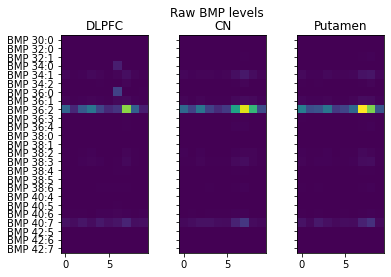

In [6]:
fig, ax = heatmap('BMP', is_normalized=False)

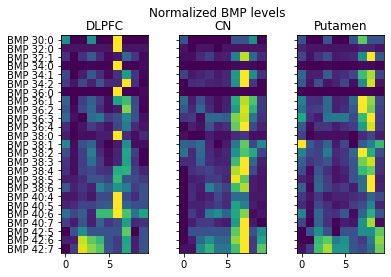

In [7]:
fig, ax = heatmap('BMP', is_normalized=True)

### Lipid group: Sulf

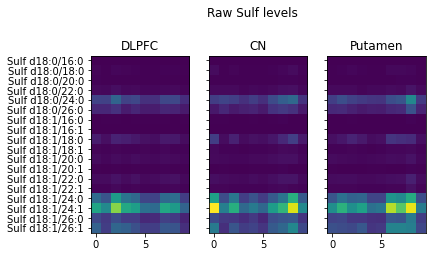

In [8]:
fig, ax = heatmap('Sulf', is_normalized=False)

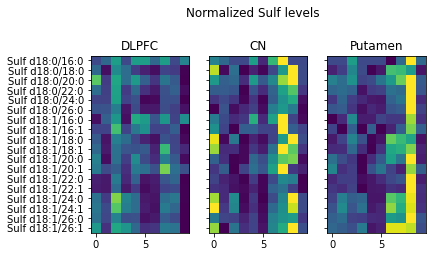

In [9]:
fig, ax = heatmap('Sulf', is_normalized=True)

### Lipid group: PG

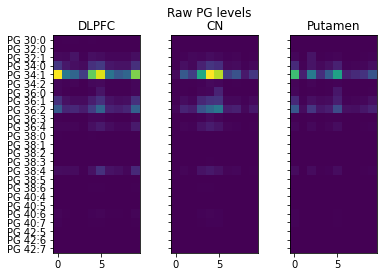

In [10]:
fig, ax = heatmap('PG', is_normalized=False)

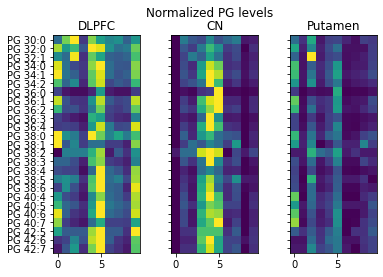

In [11]:
fig, ax = heatmap('PG', is_normalized=True)

## Fitting linear fixed and mixed models

TODO: describe models

In [12]:
def extract_group(group, df=data):
    val = df.xs(group, axis=0, level='Group')
    return(val)

def fit_to_group(formula, group, effects='mixed', df=normdata):
    d = extract_group(group, df)
    if effects == 'mixed':
        md = smf.mixedlm(formula, data=d, groups='Subject')
    if effects == 'fixed':
        md = smf.ols(formula, data=d)
    mdf = md.fit()
    return(mdf)

In [13]:
formulas = ['Level ~ 1', 'Level ~ 1 + Dx', 'Level ~ 1 + Region', 'Level ~ 1 + Dx:Region', 'Level ~ 1 + Dx + Dx:Region', 'Level ~ 1 + Dx + Region + Dx:Region']
#sel_groups = ['BMP', 'Sulf', 'PG']

In [14]:
def fit_all_models_to_group(group, formulas, normdata=normdata):
    effects = ['fixed', 'mixed']
    l = [[fit_to_group(f, group, fx, df=normdata) for f in formulas] for fx in effects]
    ix = pd.MultiIndex.from_product([effects, formulas])
    res = pd.DataFrame({group: itertools.chain(*l)}, index=ix)
    return(res)

fitted_models = pd.concat([fit_all_models_to_group(group, formulas) for group in lipid_groups.index], axis=1)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimiz

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optim

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimiz

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 5.043945
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarn

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optim

## Goodness of fit: Jarque-Bera test

Here I perform the [Jarque-Bera goodness of fit test](https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test).  The test results show that
1. the goodness of fit depends far more on the data set (lipid group) than on the specific model
1. the residuals are non-normal for all lipid groups with the notable exception of FC
1. adding the random effects of individuals improves fit
1. the adding the Dx:Region interaction term substantially improves the fit

In [15]:
fitted_models.applymap(lambda m: sms.jarque_bera(m.resid)[1])

FC             CE  \
fixed Level ~ 1                            0.600914  2.726765e-101   
      Level ~ 1 + Dx                       0.606555  1.712143e-100   
      Level ~ 1 + Region                   0.684458  1.720753e-105   
      Level ~ 1 + Dx:Region                0.800987   5.233809e-89   
      Level ~ 1 + Dx + Dx:Region           0.800987   5.233809e-89   
      Level ~ 1 + Dx + Region + Dx:Region  0.800987   5.233809e-89   
mixed Level ~ 1                            0.603594   3.078915e-63   
      Level ~ 1 + Dx                       0.614444   1.175806e-62   
      Level ~ 1 + Region                   0.685593   2.919152e-75   
      Level ~ 1 + Dx:Region                0.804884   3.572815e-67   
      Level ~ 1 + Dx + Dx:Region           0.804884   3.572815e-67   
      Level ~ 1 + Dx + Region + Dx:Region  0.804884   3.572815e-67   

                                                     AC            MG  \
fixed Level ~ 1                            3.407450e-72  1.634500e-32   
      Level ~ 1 + Dx                       5.703453e-63  2.114398e-25   
      Level ~ 1 + Region                   7.105790e-68  1.607621e-31   
      Level ~ 1 + Dx:Region                4.776086e-56  9.384032e-21   
      Level ~ 1 + Dx + Dx:Region           4.776086e-56  9.384032e-21   
      Level ~ 1 + Dx + Region + Dx:Region  4.776086e-56  9.384032e-21   
mixed Level ~ 1                            2.670149e-42  6.136842e-20   
      Level ~ 1 + Dx                       5.119357e-42  4.057672e-19   
      Level ~ 1 + Region                   3.521980e-43  5.879369e-20   
      Level ~ 1 + Dx:Region                6.758366e-39  7.215588e-17   
      Level ~ 1 + Dx + Dx:Region           6.758366e-39  7.215588e-17   
      Level ~ 1 + Dx + Region + Dx:Region  6.758366e-39  7.215588e-17   

                                                     DG             TG  \
fixed Level ~ 1                            1.783155e-35   0.000000e+00   
      Level ~ 1 + Dx                       2.124577e-36   0.000000e+00   
      Level ~ 1 + Region                   5.982841e-35   0.000000e+00   
      Level ~ 1 + Dx:Region                7.955747e-38   0.000000e+00   
      Level ~ 1 + Dx + Dx:Region           7.955747e-38   0.000000e+00   
      Level ~ 1 + Dx + Region + Dx:Region  7.955747e-38   0.000000e+00   
mixed Level ~ 1                            9.497770e-25  1.630085e-302   
      Level ~ 1 + Dx                       9.572851e-25  1.180242e-300   
      Level ~ 1 + Region                   1.858616e-24   0.000000e+00   
      Level ~ 1 + Dx:Region                6.874043e-25  3.365232e-264   
      Level ~ 1 + Dx + Dx:Region           6.874043e-25  3.365232e-264   
      Level ~ 1 + Dx + Region + Dx:Region  6.874043e-25  3.365232e-264   

                                                    Cer         dhCer  \
fixed Level ~ 1                            2.212698e-11  4.612063e-12   
      Level ~ 1 + Dx                       2.199304e-11  8.683342e-12   
      Level ~ 1 + Region                   1.081445e-09  7.266547e-10   
      Level ~ 1 + Dx:Region                1.917262e-09  2.487299e-09   
      Level ~ 1 + Dx + Dx:Region           1.917262e-09  2.487299e-09   
      Level ~ 1 + Dx + Region + Dx:Region  1.917262e-09  2.487299e-09   
mixed Level ~ 1                            1.620583e-07  4.057418e-08   
      Level ~ 1 + Dx                       4.066685e-07  3.104324e-08   
      Level ~ 1 + Region                   2.987407e-06  3.108522e-06   
      Level ~ 1 + Dx:Region                5.437541e-06  2.199885e-06   
      Level ~ 1 + Dx + Dx:Region           5.437541e-06  2.199885e-06   
      Level ~ 1 + Dx + Region + Dx:Region  5.437541e-06  2.199885e-06   

                                                      SM          dhSM  ...  \
fixed Level ~ 1                            3.450938e-132  6.406287e-08  ...   
      Level ~ 1 + Dx                       5.841590e-141  5.677797e-08  ...   
      Level ~ 1 + Region              

<ipython-input-16-6d0ca097f958>:17: RuntimeWarning: divide by zero encountered in log10
  fun = lambda m: np.log10(sms.jarque_bera(m.resid)[1])


<AxesSubplot:title={'center':'Linear mixed effects models'}>

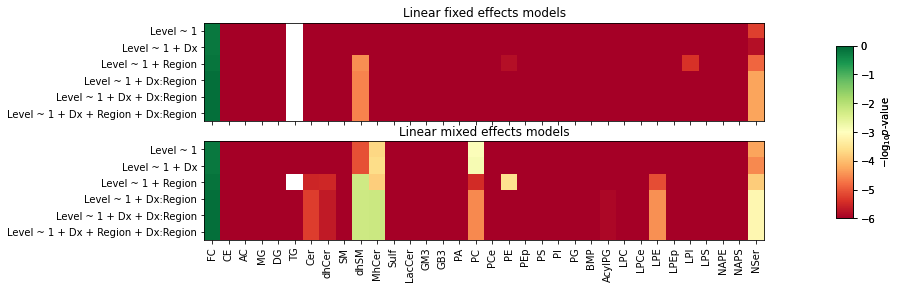

In [16]:
def imshow_model_property(ax, fun, effects='fixed', vmin=-6, vmax=0, cmap='RdYlGn', fitted_models=fitted_models):
    data = fitted_models.xs(effects, level=0, axis=0)
    image = data.applymap(fun)
    ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title('Linear ' + effects + ' effects models')
    ax.set_xticks(range(data.shape[1]))
    ax.set_xticklabels(data.columns, rotation=90)
    ax.set_yticks(range(data.shape[0]))
    ax.set_yticklabels(data.index)
    cm = plt.cm.ScalarMappable(cmap=cmap)
    cm.set_clim(vmin=vmin, vmax=vmax)
    cb_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
    fig.colorbar(cm, cax=cb_ax, label=r'$- \log_{10}p$-value')
    return(ax)

fig, ax = plt.subplots(2, 1, figsize=(12, 4), sharex=True)
fun = lambda m: np.log10(sms.jarque_bera(m.resid)[1])
imshow_model_property(ax[0], fun, 'fixed')
imshow_model_property(ax[1], fun, 'mixed')

In [17]:
%connect_info

{
  "shell_port": 50482,
  "iopub_port": 50483,
  "stdin_port": 50484,
  "control_port": 50486,
  "hb_port": 50485,
  "ip": "127.0.0.1",
  "key": "73f86017-1308ee30fb20e42b70b5a750",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-5b5c1f05-f93a-4dd1-82cf-4283a8a74864.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
